In [79]:
from typing import Literal, Optional, Union
from numpy import ndarray
from scipy.sparse import issparse, spmatrix
import warnings
from scvelo import logging as logg

def l2_norm(array, axis=None):
    return np.linalg.norm(array, ord=2, axis=axis)
def get_neighs(adata, mode="distances"):
    """TODO."""
    if hasattr(adata, "obsp") and mode in adata.obsp.keys():
        return adata.obsp[mode]
    elif "neighbors" in adata.uns.keys() and mode in adata.uns["neighbors"]:
        return adata.uns["neighbors"][mode]
    else:
        raise ValueError("The selected mode is not valid.")
def sum(a: Union[ndarray, spmatrix], axis: Optional[int] = None) -> ndarray:
    """Sum array elements over a given axis.

    Arguments
    ---------
    a
        Elements to sum.
    axis
        Axis along which to sum elements. If `None`, all elements will be summed.
        Defaults to `None`.

    Returns
    -------
    ndarray
        Sum of array along given axis.
    """
    if a.ndim == 1:
        axis = 0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return a.sum(axis=axis).A1 if issparse(a) else a.sum(axis=axis)
def get_indices(dist, n_neighbors=None, mode_neighbors="distances"):
    """TODO."""
    from scvelo.preprocessing.neighbors import compute_connectivities_umap

    D = dist.copy()
    D.data += 1e-6

    n_counts = sum(D > 0, axis=1)
    n_neighbors = (
        n_counts.min() if n_neighbors is None else min(n_counts.min(), n_neighbors)
    )
    rows = np.where(n_counts > n_neighbors)[0]
    cumsum_neighs = np.insert(n_counts.cumsum(), 0, 0)
    dat = D.data

    for row in rows:
        n0, n1 = cumsum_neighs[row], cumsum_neighs[row + 1]
        rm_idx = n0 + dat[n0:n1].argsort()[n_neighbors:]
        dat[rm_idx] = 0
    D.eliminate_zeros()

    D.data -= 1e-6
    if mode_neighbors == "distances":
        indices = D.indices.reshape((-1, n_neighbors))
    elif mode_neighbors == "connectivities":
        knn_indices = D.indices.reshape((-1, n_neighbors))
        knn_distances = D.data.reshape((-1, n_neighbors))
        _, conn = compute_connectivities_umap(
            knn_indices, knn_distances, D.shape[0], n_neighbors
        )
        indices = get_indices_from_csr(conn)
    return indices, D

def velocity_confidence(data, vkey="velocity", copy=False):
    """Computes confidences of velocities.

    .. code:: python

        scv.tl.velocity_confidence(adata)
        scv.pl.scatter(adata, color="velocity_confidence", perc=[2, 98])

    .. image:: https://user-images.githubusercontent.com/31883718/69626334-b6df5200-1048-11ea-9171-495845c5bc7a.png
       :width: 600px


    Arguments
    ---------
    data: :class:`~anndata.AnnData`
        Annotated data matrix.
    vkey: `str` (default: `'velocity'`)
        Name of velocity estimates to be used.
    copy: `bool` (default: `False`)
        Return a copy instead of writing to adata.

    Returns
    -------
    velocity_length: `.obs`
        Length of the velocity vectors for each individual cell
    velocity_confidence: `.obs`
        Confidence for each cell
    """  # noqa E501

    adata = data.copy() if copy else data
    if vkey not in adata.layers.keys():
        raise ValueError("You need to run `tl.velocity` first.")

    V = np.array(adata.layers[vkey])

    tmp_filter = np.invert(np.isnan(np.sum(V, axis=0)))
    if f"{vkey}_genes" in adata.var.keys():
        tmp_filter &= np.array(adata.var[f"{vkey}_genes"], dtype=bool)
    if "spearmans_score" in adata.var.keys():
        tmp_filter &= adata.var["spearmans_score"].values > 0.1

    V = V[:, tmp_filter]

    V -= V.mean(1)[:, None]
    V_norm = l2_norm(V, axis=1)
    R = np.zeros(adata.n_obs)

    indices = get_indices(dist=get_neighs(adata, "distances"))[0]
    for i in range(adata.n_obs):
        Vi_neighs = V[indices[i]]
        Vi_neighs -= Vi_neighs.mean(1)[:, None]
        R[i] = np.mean(
            np.einsum("ij, j", Vi_neighs, V[i])
            / (l2_norm(Vi_neighs, axis=1) * V_norm[i])[None, :]
        )

    adata.obs[f"{vkey}_length"] = V_norm.round(2)
    adata.obs[f"{vkey}_confidence"] = np.clip(R, 0, None)

    logg.hint(f"added '{vkey}_length' (adata.obs)")
    logg.hint(f"added '{vkey}_confidence' (adata.obs)")

    if f"{vkey}_confidence_transition" not in adata.obs.keys():
        velocity_confidence_transition(adata, vkey)

    return adata if copy else None

def plot_states(
    adata,
    estimator,
    which: Literal["macrostates", "terminal_states"],
    basis: str,
    inplace: bool = False,
    fpath: Optional[str] = None,
    format: str = "eps",
    dpi: Union[int, str] = "figure",
    **kwargs,
):
    if not inplace:
        adata = adata.copy()

    states = getattr(estimator, which).cat.categories.tolist()
    if which == "macrostates":
        states = estimator._macrostates
    elif which == "terminal_states":
        states = estimator._term_states
    elif which == "initial_states":
        states = estimator._init_states
    state_names = states.assignment.cat.categories.tolist()

    adata.obs[which] = states.assignment.astype(str).astype("category").cat.reorder_categories(["nan"] + state_names)
    if which == "macrostates":
        adata.uns[f"{which}_colors"] = ["#dedede"] + states.colors
    else:
        adata.uns[f"{which}_colors"] = ["#dedede"] + states.colors.tolist()
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata,
        basis=basis,
        c=which,
        add_outline=state_names,
        ax=ax,
        **kwargs,
    )

    if fpath is not None:
        fig.savefig(fpath, format=format, transparent=True, bbox_inches="tight", dpi=dpi)

In [5]:
## download anndata
import gdown

url = 'https://drive.google.com/u/0/uc?id=1Nc_9lK9kLWwrjItsTOw10olPMUFJkkP3&export=download'
output = 'adata.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1Nc_9lK9kLWwrjItsTOw10olPMUFJkkP3&export=download
From (redirected): https://drive.google.com/uc?id=1Nc_9lK9kLWwrjItsTOw10olPMUFJkkP3&export=download&confirm=t&uuid=78a536a0-14ef-4b93-bfd1-8c63bf494215
To: /home/icb/weixu.wang/regulatory_velo/FLecS/adata.h5ad
100%|██████████| 687M/687M [00:04<00:00, 141MB/s]  


'adata.h5ad'

In [63]:
import scanpy as sc
import cellrank as cr
import scvelo as scv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [29]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [7]:
adata = sc.read_h5ad("adata.h5ad")

In [8]:
adata

AnnData object with n_obs × n_vars = 4224 × 4000
    obs: 'index', 'Seq_batch_ID', 'Amp_batch_ID', 'well_coordinates', 'Mouse_ID', 'Plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'RMT_sequence', 'Number_of_cells', 'CD34_measurement', 'FcgR3_measurement', 'n_counts_all', 'n_counts', 'velocity_self_transition'
    var: 'n_counts', 'highly_variable'
    uns: 'Batch_desc_colors', 'cebpa_ko_shortest_paths', 'cebpe_ko_shortest_paths', 'neighbors', 'pca', 'umap', 'unsorted_shortest_paths', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'X', 'velocity'
    obsp: 'connectivities', 'distances'
    varp: 'grn_adj_mat'

In [80]:
velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


In [85]:
adata.obs.loc[:,"velocity_confidence"].mean()

0.9392647392285819

In [38]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
g2 = cr.estimators.GPCCA(vk)

  0%|          | 0/4224 [00:00<?, ?cell/s]

  0%|          | 0/4224 [00:00<?, ?cell/s]

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


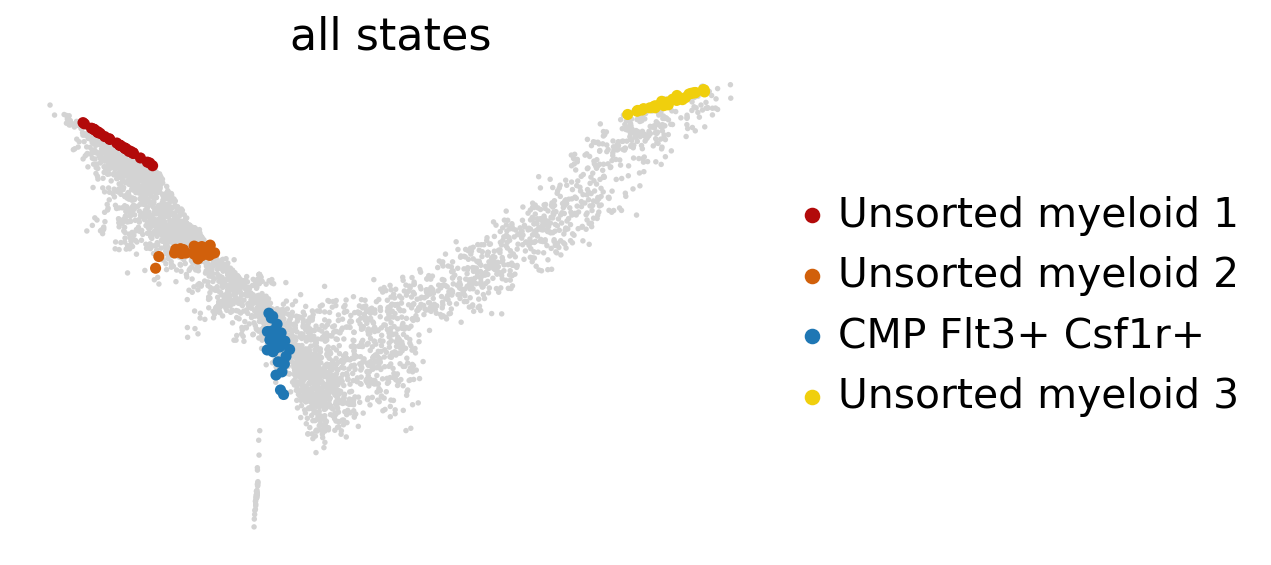

In [89]:
g2.compute_macrostates(n_states=4, cluster_key="Batch_desc")
g2.plot_macrostates(which="all",legend_loc="right",s = 100)

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


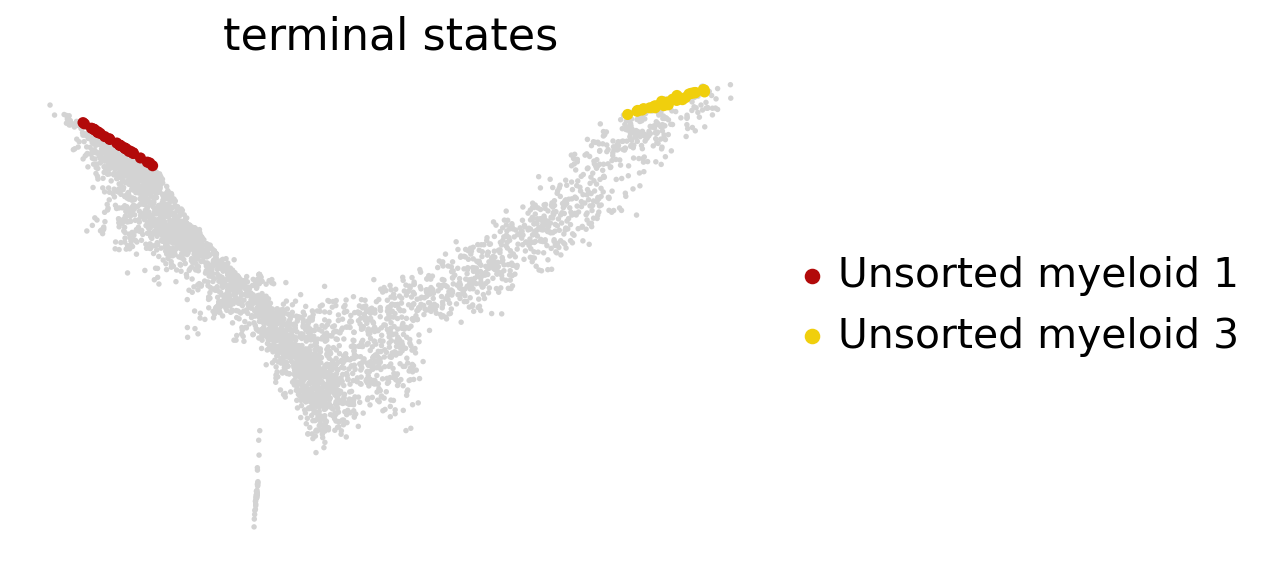

In [90]:
g2.predict_terminal_states(method = "top_n", n_states = 2)
g2.plot_macrostates(which="terminal", legend_loc="right", s = 100,basis = "umap")

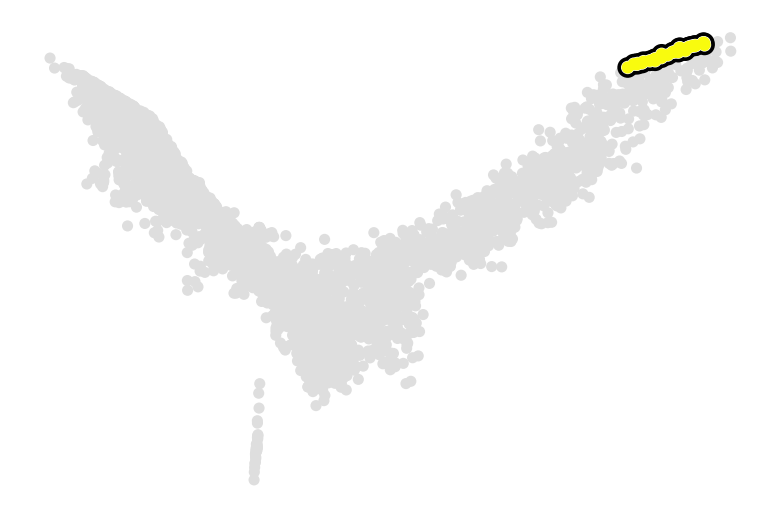

In [60]:
plot_states(
        adata,
        estimator=g2,
        which="terminal_states",
        basis="umap",
        legend_loc=False,
        title="",
        size=100,
        format="png",
        dpi = 400,
    )